In [2]:
#importing necessary libraries
import pandas as pd
import numpy as np
import re
import os

#Sklearn 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.metrics import (classification_report,precision_recall_curve,
                             balanced_accuracy_score)
#Plotting libraries better analysis
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

pd.set_option("display.max_columns", 300)
pd.set_option("display.max_rows", 300)

#warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


In [3]:
RANDOM_STATE = 42
np.bool = np.bool_

## Univariate Analysis for the given data

In [5]:
def plot_univariate(dataframe, column_names,scale='linear'):
    fig = plt.figure(figsize=(16,12))
    for idx, column_name in enumerate(column_names):
        ax = fig.add_subplot(1,len(column_names),idx + 1)
        sns.violinplot(x='churn_probability', y = column_name, data = dataframe, ax=ax)
        title = ''.join(column_name) + ' vs Churn'
        ax.set(title=title)
        if scale == 'log' :
            plt.yscale('log')
            ax.set(ylabel= column_name + '(Log Scale)') 
            
def trim_outliers(array, num_std=3):
    upper_limit = array.mean() + num_std*array.std()
    lower_limit = array.mean() - num_std*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

## Reading the given Data from the given files

In [6]:
data = pd.read_csv('train.csv')
unseen = pd.read_csv('test.csv').set_index('id')
sample = pd.read_csv('sample.csv')
data_dict= pd.read_csv('data_dictionary.csv')

In [7]:
print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 170)
(30000, 2)
(36, 2)


In [8]:
data.head()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0   0        109             0.0             0.0             0.0   
1   1        109             0.0             0.0             0.0   
2   2        109             0.0             0.0             0.0   
3   3        109             0.0             0.0             0.0   
4   4        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014   31.277   
1            6/30/2014            7/31/2014            8/31/2014    0.000   
2            6/30/2014            7/31/2014            8/31/2014   60.806   
3            6/30/2014            7/31/2014            8/31/2014  156.362   
4            6/30/2014            7/31/2014            8/31/2014  240.708   

    arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  \
0   87.009    7.527        48.58       124.38         1.29         32.24   
1  122.787   42.953         0.00         0.00         0.00          0.00   
2  103.176    0.000         0.53        15.93         0.00         53.99   
3  205.260  111.095         7.26        16.01         0.00         68.76   
4  128.191  101.565        21.28         4.83         6.13         56.99   

   offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0         96.68          2.33           0.00            0.0            0.0   
1         25.99         30.89           0.00            0.0            0.0   
2         82.05          0.00           0.00            0.0            0.0   
3         78.48         50.23           0.00            0.0            0.0   
4         38.11          9.63          53.64            0.0            0.0   

   roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
0           0.00            0.0           0.00              2.23   
1           0.00            0.0           0.00              0.00   
2           0.00            0.0           0.00              0.53   
3           0.00            0.0           1.63              6.99   
4          15.73            0.0           0.00             10.16   

   loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
0              0.00              0.28              5.29             16.04   
1              0.00              0.00              0.00              0.00   
2             12.98              0.00             24.11              0.00   
3              3.94              0.00             37.91             44.89   
4              4.83              6.13             36.74             19.88   

   loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
0              2.33              0.00              0.00              0.00   
1              0.00              0.00              0.00              0.00   
2              0.00              0.00              0.00              0.00   
3             23.63              0.00              0.00              0.00   
4              4.61             11.99              1.23              5.01   

   loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
0              0.00              0.00              0.00          7.53   
1              0.00             22.01             29.79          0.00   
2              2.14              0.00              0.00         24.64   
3              0.00              0.00              8.03         44.91   
4              0.00              9.85              0.00         58.91   

   loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  \
0         16.04          2.61             46.34            124.38   
1          0.00          0.00              0.00              0.00   
2         12.98          0.00              0.00              2.94   
3         48.84         23.63              0.26             12.06   
4         25.94         15.76              0.00              0.00   

   std_og_t2t_mo

## Data Understanding, Preparation, and Pre-Processing

In [9]:
churn = data.copy().set_index('id')
del data
churn.head(5)

circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
id                                                              
0         109             0.0             0.0             0.0   
1         109             0.0             0.0             0.0   
2         109             0.0             0.0             0.0   
3         109             0.0             0.0             0.0   
4         109             0.0             0.0             0.0   

   last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
id                                                                           
0             6/30/2014            7/31/2014            8/31/2014   31.277   
1             6/30/2014            7/31/2014            8/31/2014    0.000   
2             6/30/2014            7/31/2014            8/31/2014   60.806   
3             6/30/2014            7/31/2014            8/31/2014  156.362   
4             6/30/2014            7/31/2014            8/31/2014  240.708   

     arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  \
id                                                                          
0    87.009    7.527        48.58       124.38         1.29         32.24   
1   122.787   42.953         0.00         0.00         0.00          0.00   
2   103.176    0.000         0.53        15.93         0.00         53.99   
3   205.260  111.095         7.26        16.01         0.00         68.76   
4   128.191  101.565        21.28         4.83         6.13         56.99   

    offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
id                                                                            
0          96.68          2.33           0.00            0.0            0.0   
1          25.99         30.89           0.00            0.0            0.0   
2          82.05          0.00           0.00            0.0            0.0   
3          78.48         50.23           0.00            0.0            0.0   
4          38.11          9.63          53.64            0.0            0.0   

    roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
id                                                                  
0            0.00            0.0           0.00              2.23   
1            0.00            0.0           0.00              0.00   
2            0.00            0.0           0.00              0.53   
3            0.00            0.0           1.63              6.99   
4           15.73            0.0           0.00             10.16   

    loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
id                                                                           
0               0.00              0.28              5.29             16.04   
1               0.00              0.00              0.00              0.00   
2              12.98              0.00             24.11              0.00   
3               3.94              0.00             37.91             44.89   
4               4.83              6.13             36.74             19.88   

    loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
id                                                                           
0               2.33              0.00              0.00              0.00   
1               0.00              0.00              0.00              0.00   
2               0.00              0.00              0.00              0.00   
3              23.63              0.00              0.00              0.00   
4               4.61             11.99              1.23              5.01   

    loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
id                                                                       
0               0.00              0.00              0.00          7.53   
1               0.00             22.01             29.79          0.00   
2               2.14             

#### Plotting for Churn_Probability

<AxesSubplot:xlabel='churn_probability', ylabel='Density'>

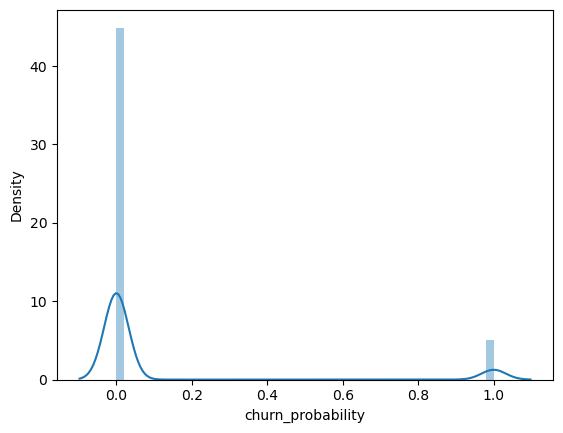

In [10]:
sns.distplot(churn.churn_probability>0.5)

In [11]:
# feature type summary from the data
churn.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69999 entries, 0 to 69998
Data columns (total 171 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    circle_id                 int64  
 1    loc_og_t2o_mou            float64
 2    std_og_t2o_mou            float64
 3    loc_ic_t2o_mou            float64
 4    last_date_of_month_6      object 
 5    last_date_of_month_7      object 
 6    last_date_of_month_8      object 
 7    arpu_6                    float64
 8    arpu_7                    float64
 9    arpu_8                    float64
 10   onnet_mou_6               float64
 11   onnet_mou_7               float64
 12   onnet_mou_8               float64
 13   offnet_mou_6              float64
 14   offnet_mou_7              float64
 15   offnet_mou_8              float64
 16   roam_ic_mou_6             float64
 17   roam_ic_mou_7             float64
 18   roam_ic_mou_8             float64
 19   roam_og_mou_6             float64
 20   roam

#### Some of the columns above are in a different format - jun_vbc_3g, aug_vbc_3g.Lets rename them to match the format which ends with month.

In [12]:
churn = churn.rename(columns= {'jun_vbc_3g' : 'vbc_3g_6', 'jul_vbc_3g' : 'vbc_3g_7', 'aug_vbc_3g' : 'vbc_3g_8', 'sep_vbc_3g' : 'vbc_3g_9'})
unseen  = unseen.rename(columns= {'jun_vbc_3g' : 'vbc_3g_6', 'jul_vbc_3g' : 'vbc_3g_7', 'aug_vbc_3g' : 'vbc_3g_8', 'sep_vbc_3g' : 'vbc_3g_9'})

In [13]:
churn.sample(5,random_state=RANDOM_STATE)

circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
id                                                                 
57621        109             0.0             0.0             0.0   
39559        109             0.0             0.0             0.0   
41415        109             0.0             0.0             0.0   
47731        109             0.0             0.0             0.0   
64801        109             0.0             0.0             0.0   

      last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
id                                                                     
57621            6/30/2014            7/31/2014            8/31/2014   
39559            6/30/2014            7/31/2014            8/31/2014   
41415            6/30/2014            7/31/2014            8/31/2014   
47731            6/30/2014            7/31/2014            8/31/2014   
64801            6/30/2014            7/31/2014            8/31/2014   

         arpu_6    arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
id                                                                          
57621  1127.020  1363.096  421.153       365.19       402.24       165.88   
39559   517.241   407.339  426.689       112.28       126.01        99.61   
41415   648.204   586.811  618.653       777.76       766.84       802.01   
47731   245.917   177.315  132.963       172.14        83.96        84.58   
64801   891.619   765.631  920.688       475.13       419.36       650.71   

       offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
id                                                                              
57621        216.56        168.61         57.63            0.0           0.00   
39559        226.66        358.43        423.01            0.0           0.00   
41415        424.31        220.96        351.34            0.0           0.00   
47731        171.76         59.28         23.11            0.0           0.00   
64801        867.71        615.79        610.68            0.0          35.04   

       roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
id                                                                  
57621            0.0            0.0           0.00            0.0   
39559            0.0            0.0           0.00            0.0   
41415            0.0            0.0           0.00            0.0   
47731            0.0            0.0           0.00            0.0   
64801            0.0            0.0         116.76            0.0   

       loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
id                                                                              
57621            270.01            351.88            115.99            106.69   
39559            101.79            105.26             81.89             82.16   
41415              0.00              4.98             12.29             15.41   
47731              4.79              8.24              1.46             38.46   
64801             76.21             81.01            160.69            226.74   

       loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
id                                                                              
57621             28.99             36.94             10.26              1.83   
39559             89.83             74.94              1.36              0.00   
41415             25.64             12.54              0.00              0.00   
47731             51.26             15.49              0.00              0.00   
64801            161.31            169.76              1.03              3.29   

       loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
id                                                                              
57621              3.38              0.00              0.00              0.00   
39559              0.00              0.00             

In [14]:
# look at data statistics
churn.describe(include='all')

circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
count     69999.0         69297.0         69297.0         69297.0   
unique        NaN             NaN             NaN             NaN   
top           NaN             NaN             NaN             NaN   
freq          NaN             NaN             NaN             NaN   
mean        109.0             0.0             0.0             0.0   
std           0.0             0.0             0.0             0.0   
min         109.0             0.0             0.0             0.0   
25%         109.0             0.0             0.0             0.0   
50%         109.0             0.0             0.0             0.0   
75%         109.0             0.0             0.0             0.0   
max         109.0             0.0             0.0             0.0   

       last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
count                 69999                69600                69266   
unique                    1                    1                    1   
top               6/30/2014            7/31/2014            8/31/2014   
freq                  69999                69600                69266   
mean                    NaN                  NaN                  NaN   
std                     NaN                  NaN                  NaN   
min                     NaN                  NaN                  NaN   
25%                     NaN                  NaN                  NaN   
50%                     NaN                  NaN                  NaN   
75%                     NaN                  NaN                  NaN   
max                     NaN                  NaN                  NaN   

              arpu_6        arpu_7        arpu_8   onnet_mou_6   onnet_mou_7  \
count   69999.000000  69999.000000  69999.000000  67231.000000  67312.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean      283.134365    278.185912    278.858826    133.153275    133.894438   
std       334.213918    344.366927    351.924315    299.963093    311.277193   
min     -2258.709000  -1289.715000   -945.808000      0.000000      0.000000   
25%        93.581000     86.714000     84.095000      7.410000      6.675000   
50%       197.484000    191.588000    192.234000     34.110000     32.280000   
75%       370.791000    365.369500    369.909000    119.390000    115.837500   
max     27731.088000  35145.834000  33543.624000   7376.710000   8157.780000   

         onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  \
count   66296.000000  67231.000000  67312.000000  66296.000000   67231.000000   
unique           NaN           NaN           NaN           NaN            NaN   
top              NaN           NaN           NaN           NaN            NaN   
freq             NaN           NaN           NaN           NaN            NaN   
mean      132.978257    198.874771    197.153383    196.543577       9.765435   
std       311.896596    316.818355    322.482226    324.089234      57.374429   
min         0.000000      0.000000      0.000000      0.000000       0.000000   
25%         6.410000     34.860000     32.240000     31.575000       0.000000   
50%        32.100000     96.480000     91.885000     91.800000       0.000000   
75%       115.060000    232.990000    227.630000    229.345000       0.000000   
max     10752.560000   8362.360000   7043.980000  14007.340000    2850.980000   

        roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  \
count    67312.000000   66296.000000   67231.000000   67312.000000   
unique            NaN            NaN            NaN            NaN   
top               NaN            NaN            NaN            NaN   
freq              NaN            NaN            NaN            NaN   
mean         7.014

### Dropping the date fields

In [15]:
dates = [i for i in list(churn.columns) if re.search('date',i)]
churn = churn.drop(dates, axis=1)
unseen = unseen.drop(dates,axis=1)

In [16]:
churn.columns

Index(['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8',
       ...
       'sachet_3g_7', 'sachet_3g_8', 'fb_user_6', 'fb_user_7', 'fb_user_8',
       'aon', 'vbc_3g_8', 'vbc_3g_7', 'vbc_3g_6', 'churn_probability'],
      dtype='object', length=162)

In [17]:
unique_counts = pd.DataFrame({'Unique Counts': churn.nunique()}).sort_values(by='Unique Counts')
unique_count_cols = unique_counts[unique_counts['Unique Counts'] == 1].index.to_list()
unique_count_cols
churn = churn.drop(columns=unique_count_cols)
unseen  = unseen.drop(columns=unique_count_cols)
print(f"{len(unique_count_cols)} columns dropped.\n")

10 columns dropped.



In [18]:
binary_cols = unique_counts[unique_counts['Unique Counts'] == 2].index.to_list()
binary_cols = list(filter(lambda x:x!='churn_probability',binary_cols))
churn.loc[:,binary_cols] = churn.loc[:,binary_cols].astype('category')
unseen.loc[:,binary_cols] = unseen.loc[:,binary_cols].astype('category')
print(f"{len(binary_cols)} columns made categorical.{binary_cols}\n")

6 columns made categorical.['fb_user_8', 'fb_user_7', 'fb_user_6', 'night_pck_user_8', 'night_pck_user_7', 'night_pck_user_6']



#### Plotting Analysis for Churn_Probability With Recharge Amount

In [19]:
plt.figure(figsize=(15,15))
plt.subplot(2,3,1)
sns.boxplot(x='churn_probability',y='last_day_rch_amt_6',hue='churn_probability', data=churn,showfliers=False,palette=("plasma"))
plt.subplot(2,3,2)
sns.boxplot(x='churn_probability',y='last_day_rch_amt_7',hue='churn_probability', data=churn,showfliers=False,palette=("plasma"))
plt.subplot(2,3,3)
sns.boxplot(x='churn_probability',y='last_day_rch_amt_8',hue='churn_probability', data=churn,showfliers=False,palette=("plasma"))
plt.subplot(2,3,4)
sns.boxplot(x='churn_probability',y='max_rech_amt_6',hue='churn_probability', data=churn,showfliers=False,palette=("plasma"))
plt.subplot(2,3,5)
sns.boxplot(x='churn_probability',y='max_rech_amt_7',hue='churn_probability', data=churn,showfliers=False,palette=("plasma"))
plt.subplot(2,3,6)
sns.boxplot(x='churn_probability',y='max_rech_amt_8',hue='churn_probability', data=churn,showfliers=False,palette=("plasma"))

plt.show()


**We are getting a huge drop in 8th month recharge amount for churned customers**

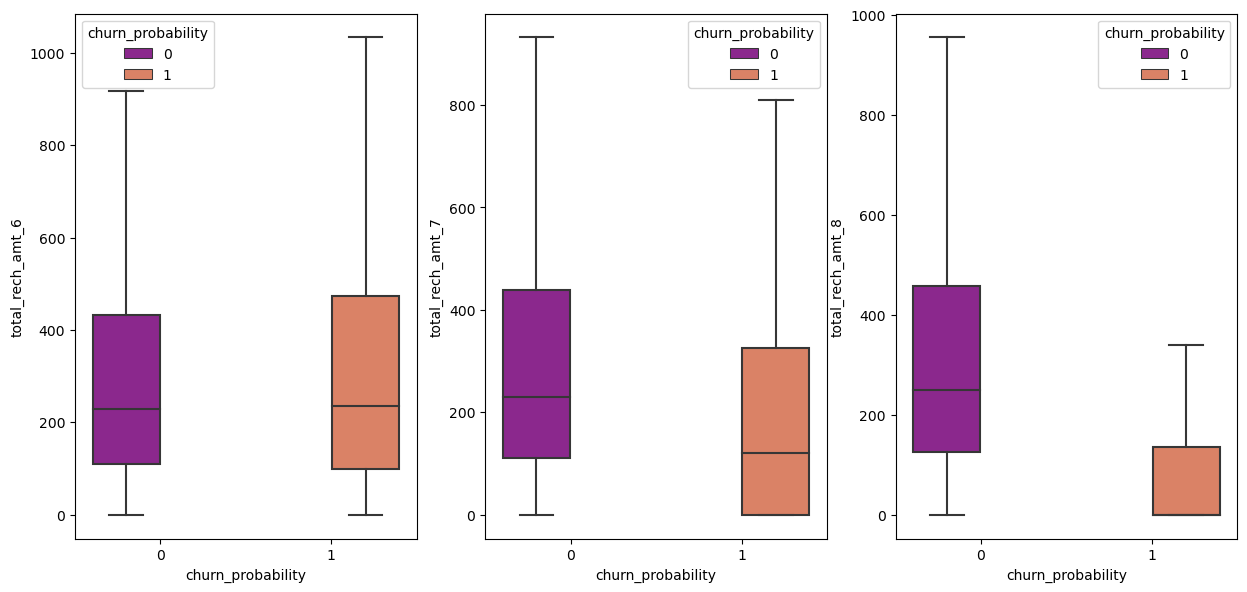

In [20]:
plt.figure(figsize=(15,15))
plt.subplot(2,3,1)
sns.boxplot(x='churn_probability',y='total_rech_amt_6',hue='churn_probability', data=churn,showfliers=False,palette=("plasma"))
plt.subplot(2,3,2)
sns.boxplot(x='churn_probability',y='total_rech_amt_7',hue='churn_probability', data=churn,showfliers=False,palette=("plasma"))
plt.subplot(2,3,3)
sns.boxplot(x='churn_probability',y='total_rech_amt_8',hue='churn_probability', data=churn,showfliers=False,palette=("plasma"))
plt.show()



We are getting a huge drop in 8th month for total recharge amount for churned customers

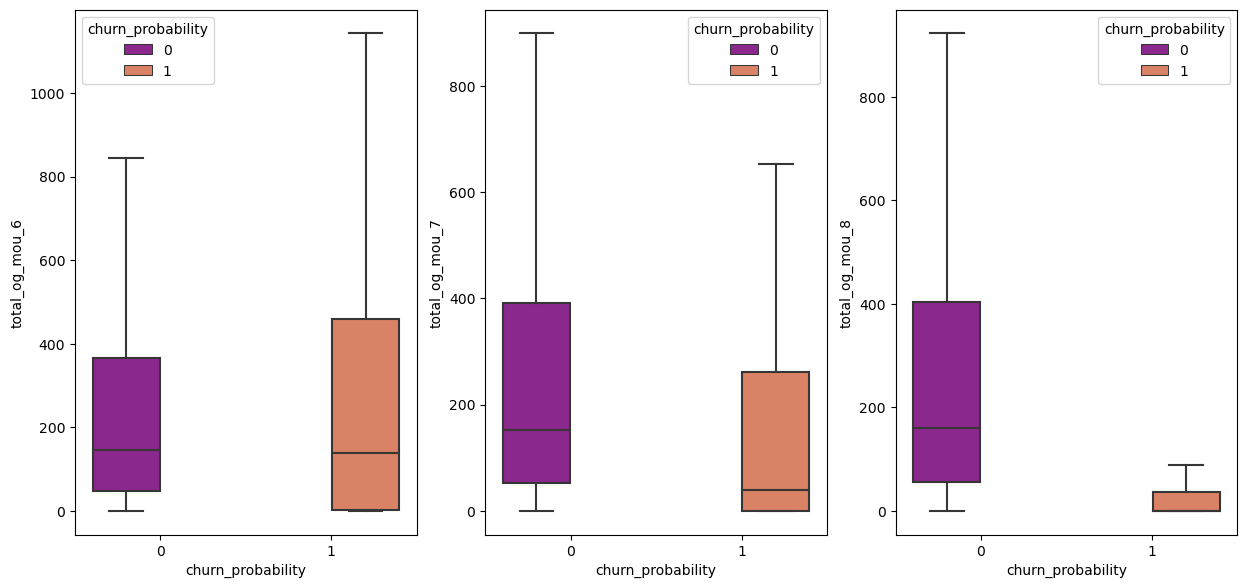

In [21]:
plt.figure(figsize=(15,15))
plt.subplot(2,3,1)
sns.boxplot(x='churn_probability',y='total_og_mou_6',hue='churn_probability', data=churn,showfliers=False,palette=("plasma"))
plt.subplot(2,3,2)
sns.boxplot(x='churn_probability',y='total_og_mou_7',hue='churn_probability', data=churn,showfliers=False,palette=("plasma"))
plt.subplot(2,3,3)
sns.boxplot(x='churn_probability',y='total_og_mou_8',hue='churn_probability', data=churn,showfliers=False,palette=("plasma"))
plt.show()

****There is huge drop in the total amount of MOU(Minutes of usage voice calls) for churned customers in the 8th Month ****

In [22]:
# Checking the customer churn distribution
ax = (churn['churn_probability'].value_counts()*100.0 /len(churn)).plot.pie(autopct='%.3f%%', 
                                                                                        labels = ['No', 'Yes'],
                                                                                        colors =['y','r'],
                                                                                        figsize =(5,5), 
                                                                                        fontsize = 12 )                                                                           

ax.set_ylabel('Churn',fontsize = 12)
ax.set_title('Churn Distribution', fontsize = 12)
plt.show()

## Exploratory Data Analysis here

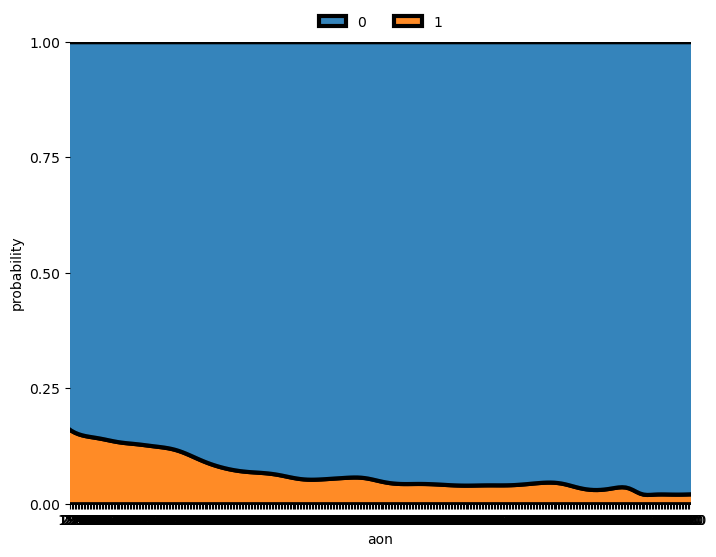

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.grid(False, axis='x')
sns.kdeplot(data=churn, x='aon', hue='churn_probability', multiple='fill', linewidth=3, ax=ax, alpha=0.9)
sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), title='', ncol=2, frameon=False)

ax.set_xticks(np.arange(0,churn['aon'].max(),10))
ax.set_xlim(churn['aon'].min(),churn['aon'].max())

ax.set_yticks(np.linspace(0,1,5))
ax.set_ylabel('probability')

sns.despine(left=True, bottom=True)

# ax.axis('tight')
plt.show()

**It is observed that probability of churned customers is high compared to non churned customers**

### Plotting churn_probability based on monthly 2g & 3g Packages

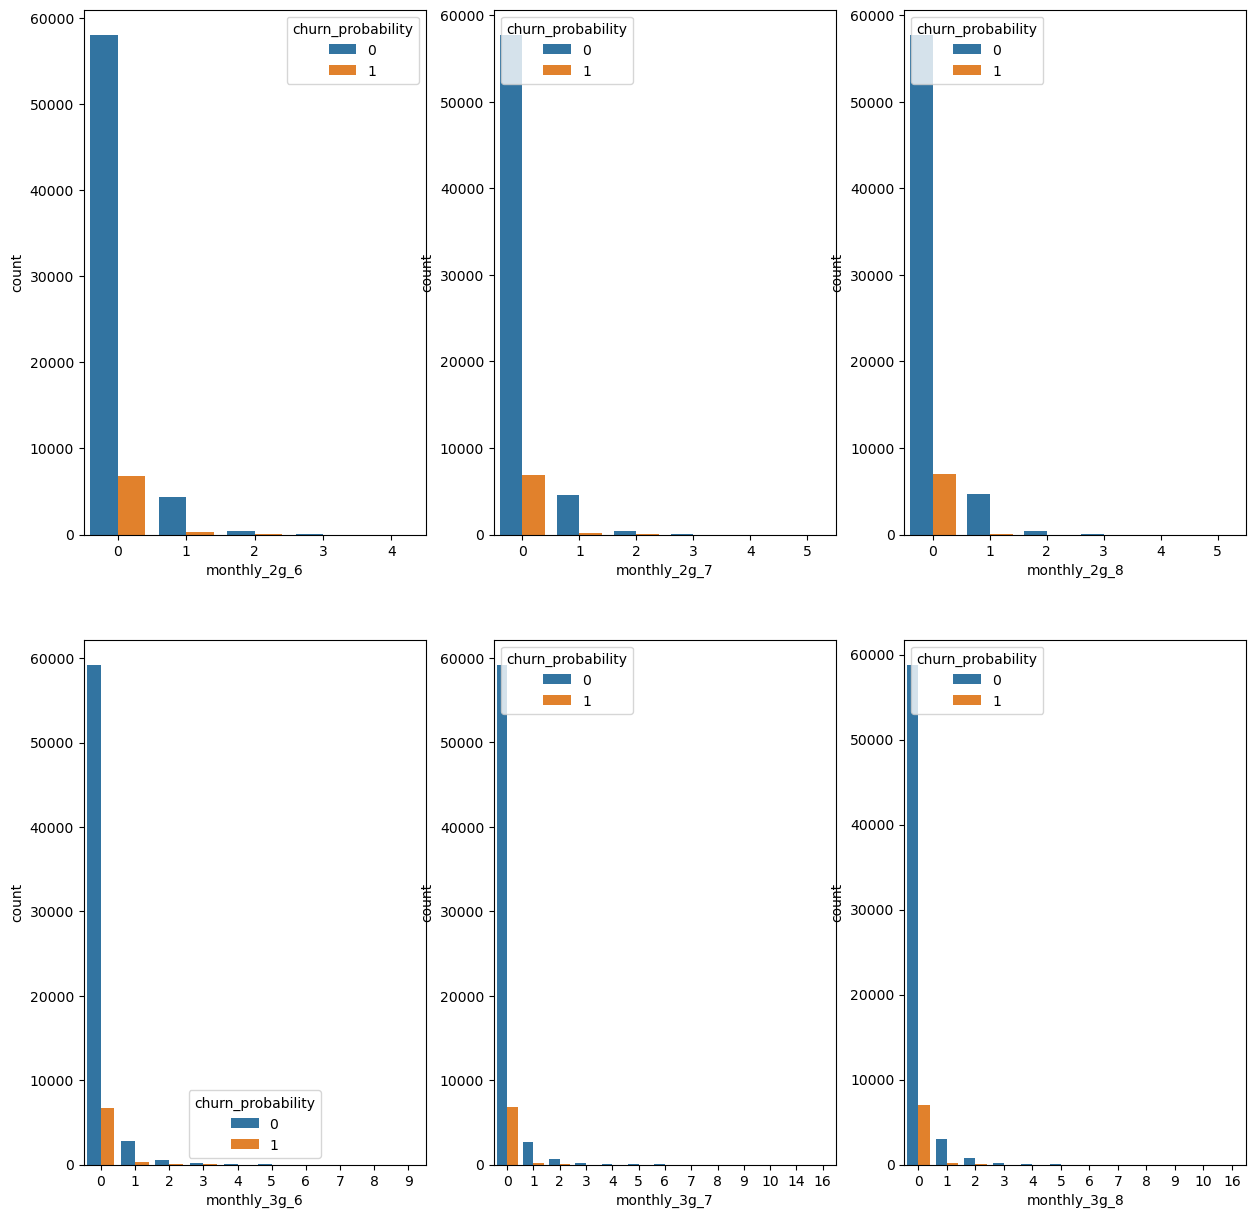

In [24]:
plt.figure(figsize=(15,15))
plt.subplot(2,3,1)
sns.countplot(x='monthly_2g_6',hue='churn_probability', data=churn)
plt.subplot(2,3,2)
sns.countplot(x='monthly_2g_7',hue='churn_probability', data=churn)
plt.subplot(2,3,3)
sns.countplot(x='monthly_2g_8',hue='churn_probability', data=churn)
plt.subplot(2,3,4)
sns.countplot(x='monthly_3g_6',hue='churn_probability', data=churn)
plt.subplot(2,3,5)
sns.countplot(x='monthly_3g_7',hue='churn_probability', data=churn)
plt.subplot(2,3,6)
sns.countplot(x='monthly_3g_8',hue='churn_probability', data=churn)

plt.show()

#### There is huge drop of churn customers in 8th Month

In [25]:
mou_cols = churn.columns[churn.columns.str.contains('mou')]
mou_og_cols6 = churn.columns[churn.columns.str.contains('.*_og_.*mou_6',regex=True)]
mou_og_cols7 = churn.columns[churn.columns.str.contains('.*_og_.*mou_7',regex=True)]
mou_og_cols8 = churn.columns[churn.columns.str.contains('.*_og_.*mou_8',regex=True)]


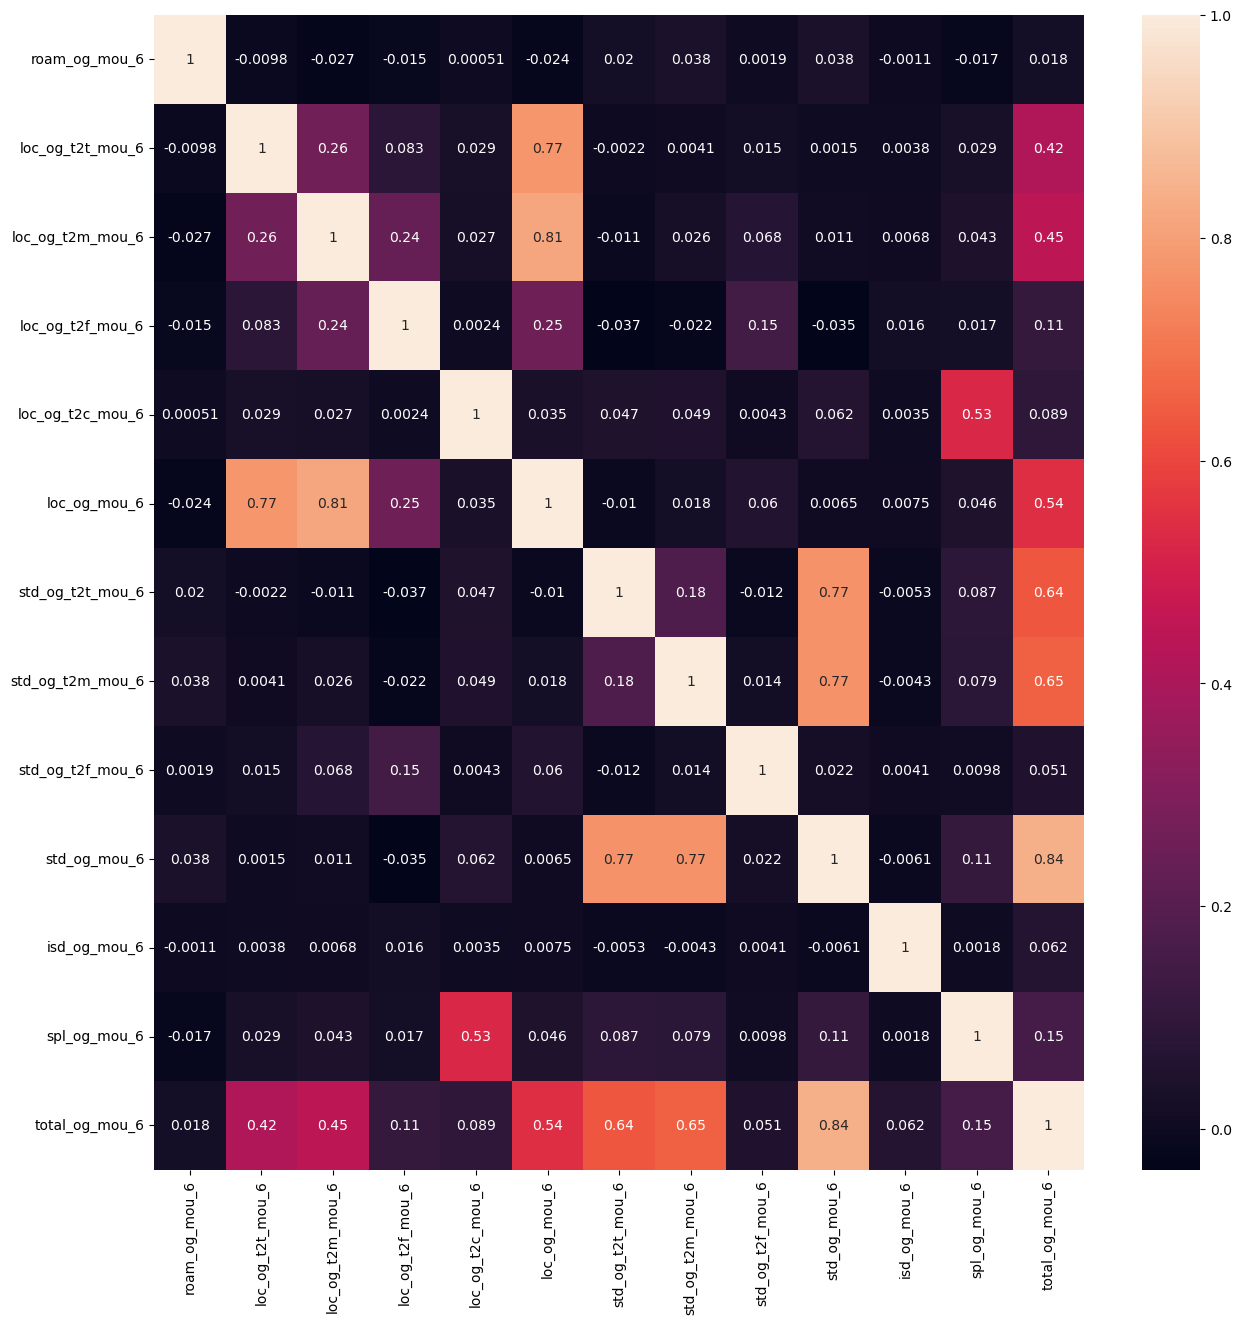

In [26]:
## finding out correlation between variables  within 6th Month
plt.figure(figsize = (15,15))
sns.heatmap(churn.filter(mou_og_cols6).corr(),annot = True)
plt.show()

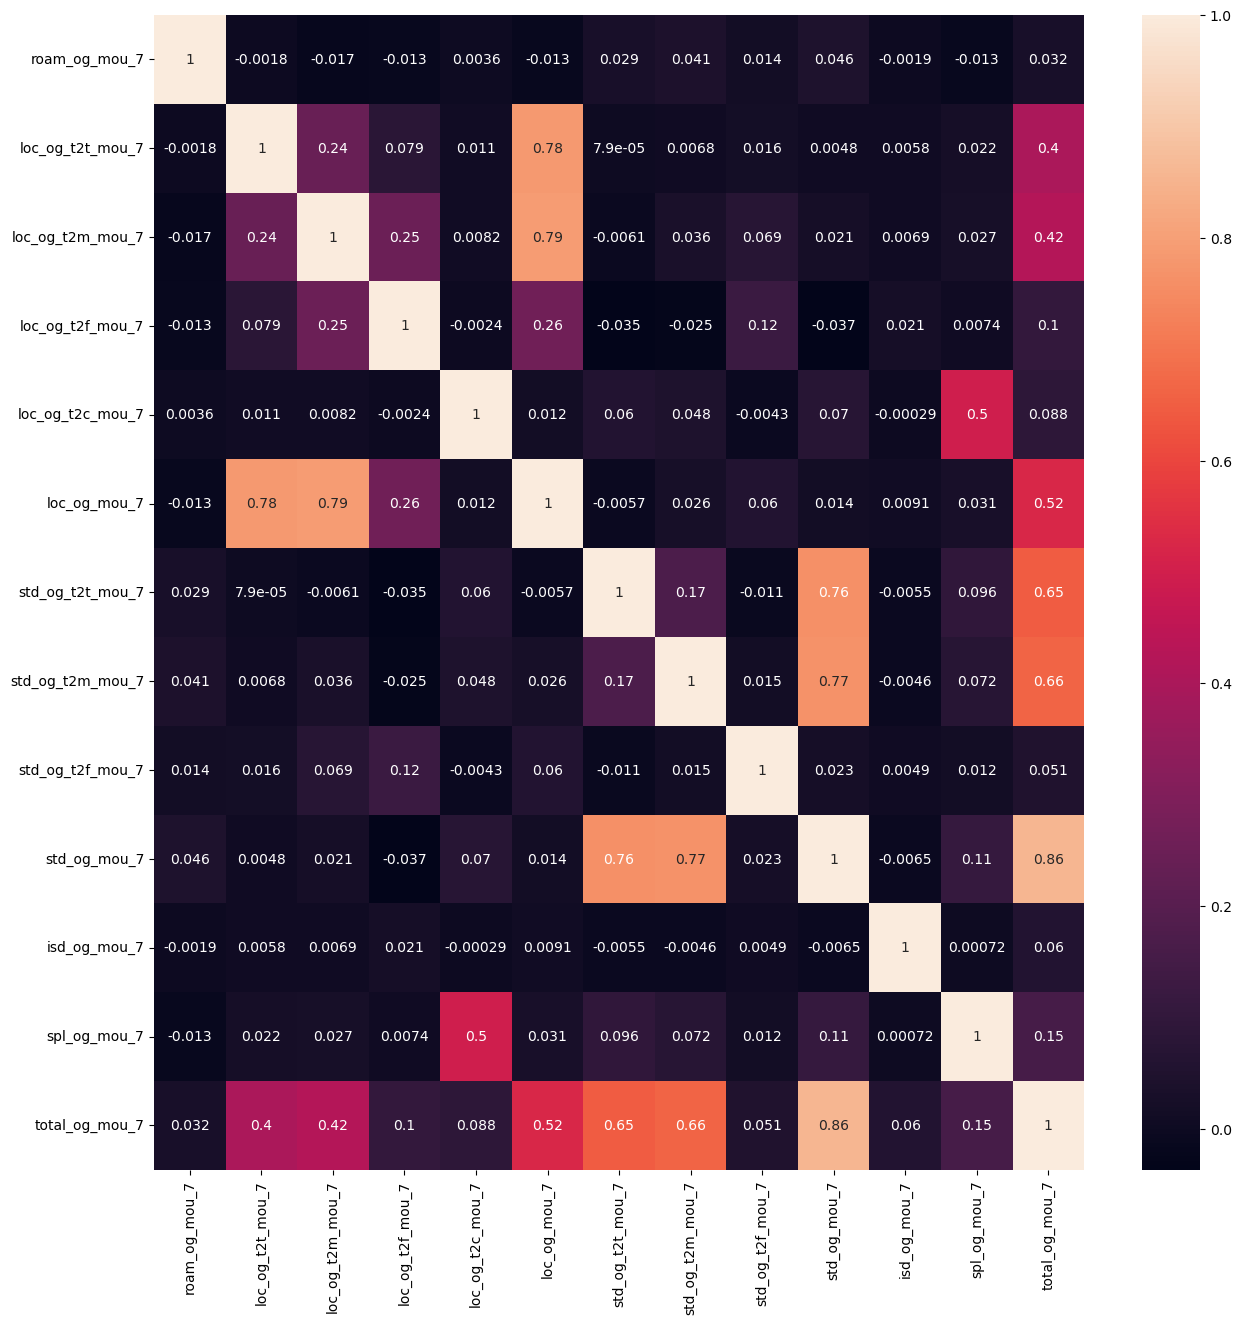

In [27]:
## finding out correlation between variables  within 7th Month
plt.figure(figsize = (15,15))
sns.heatmap(churn.filter(mou_og_cols7).corr(),annot = True)
plt.show()

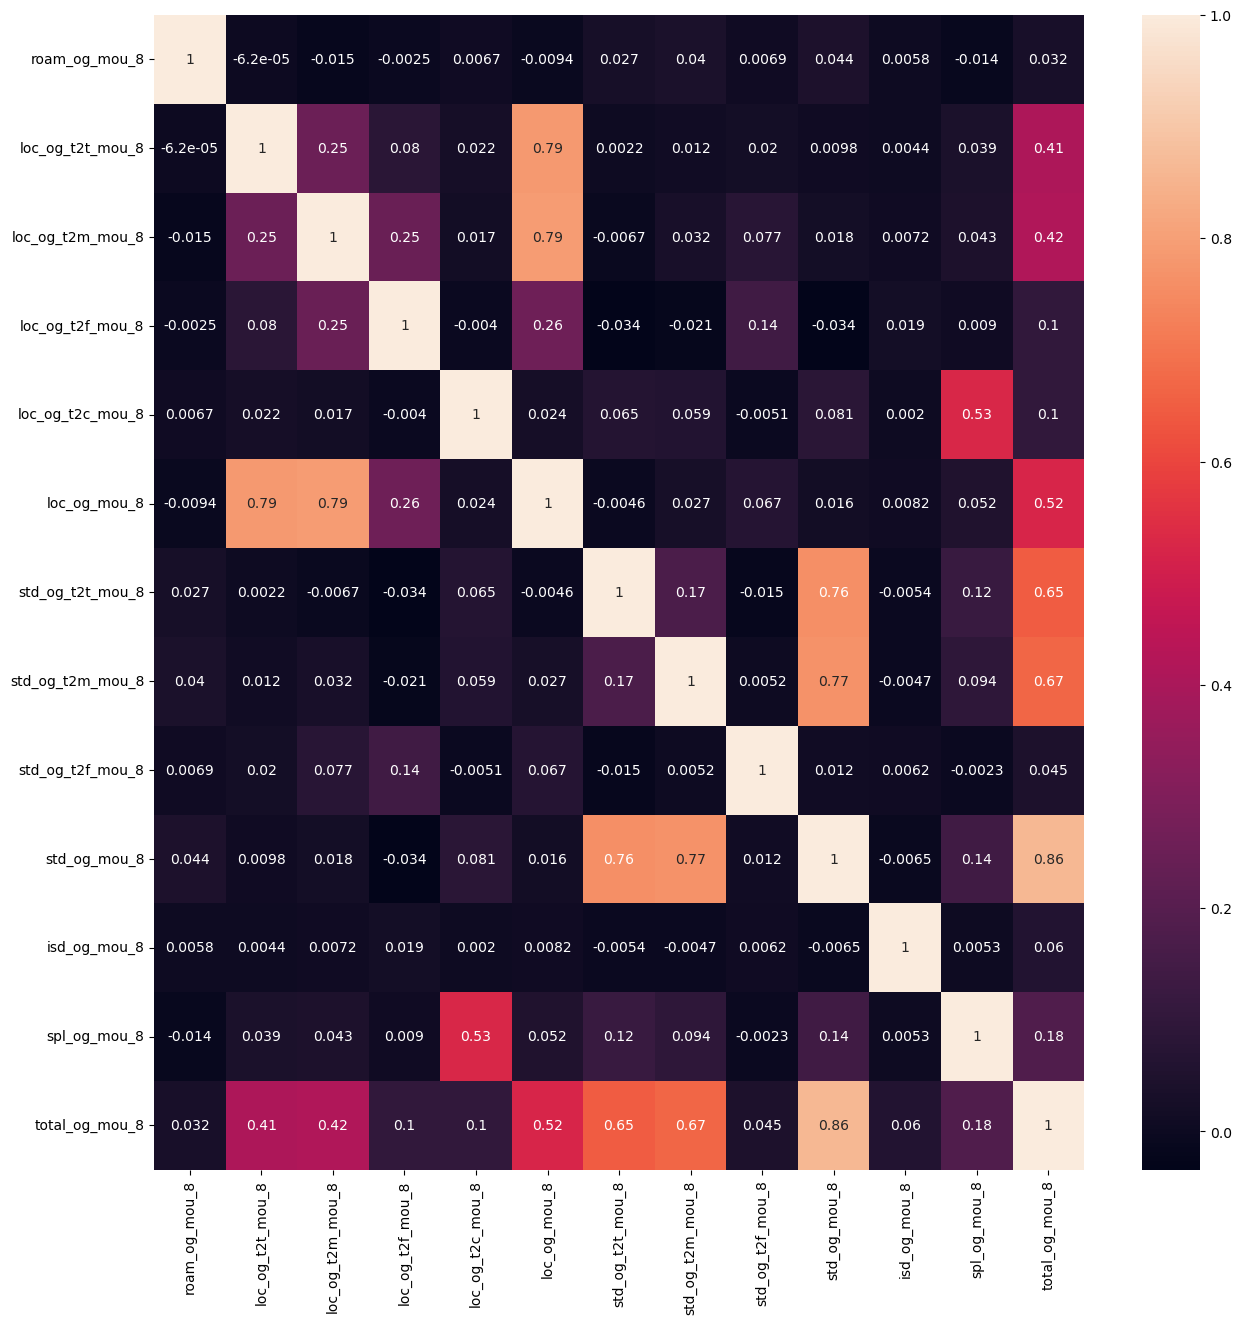

In [28]:
## finding out correlation between variables  within 8th Month
plt.figure(figsize = (15,15))
sns.heatmap(churn.filter(mou_og_cols8).corr(),annot = True)
plt.show()

In [29]:
mou_ic_cols6 = churn.columns[churn.columns.str.contains('.*_ic_.*mou_6',regex=True)]
mou_ic_cols7 = churn.columns[churn.columns.str.contains('.*_ic_.*mou_7',regex=True)]
mou_ic_cols8 = churn.columns[churn.columns.str.contains('.*_ic_.*mou_8',regex=True)]

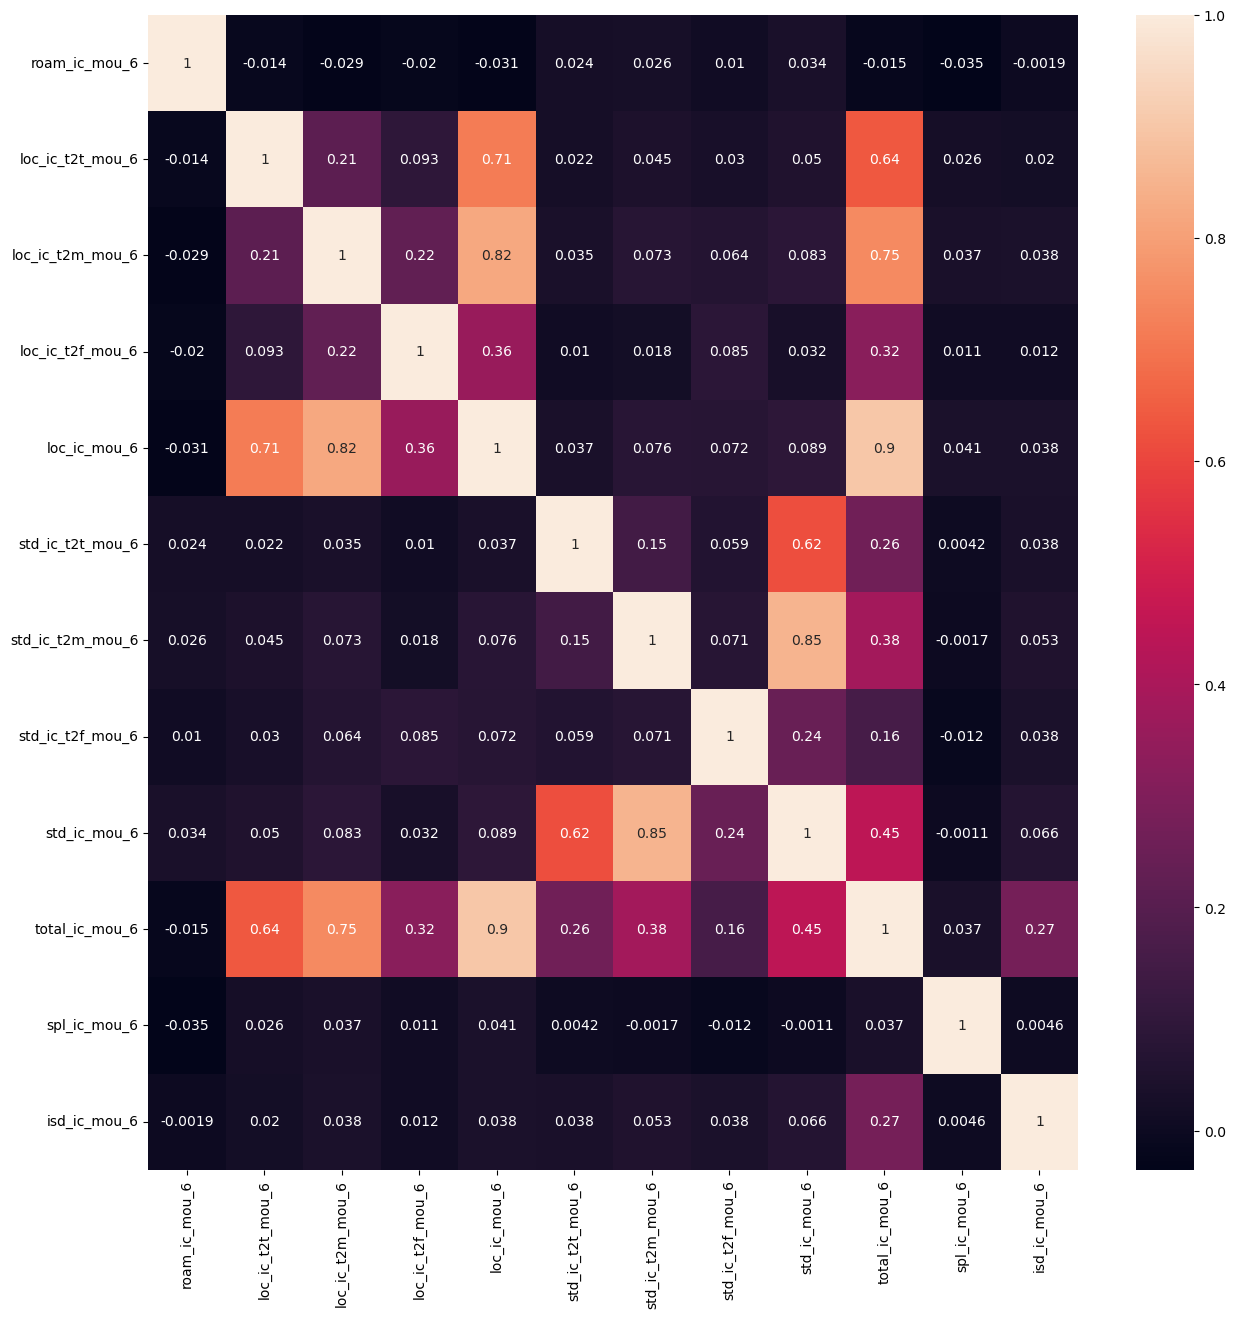

In [30]:
## finding out correlation between variables  within 6th Month
plt.figure(figsize = (15,15))
sns.heatmap(churn.filter(mou_ic_cols6).corr(),annot = True)
plt.show()

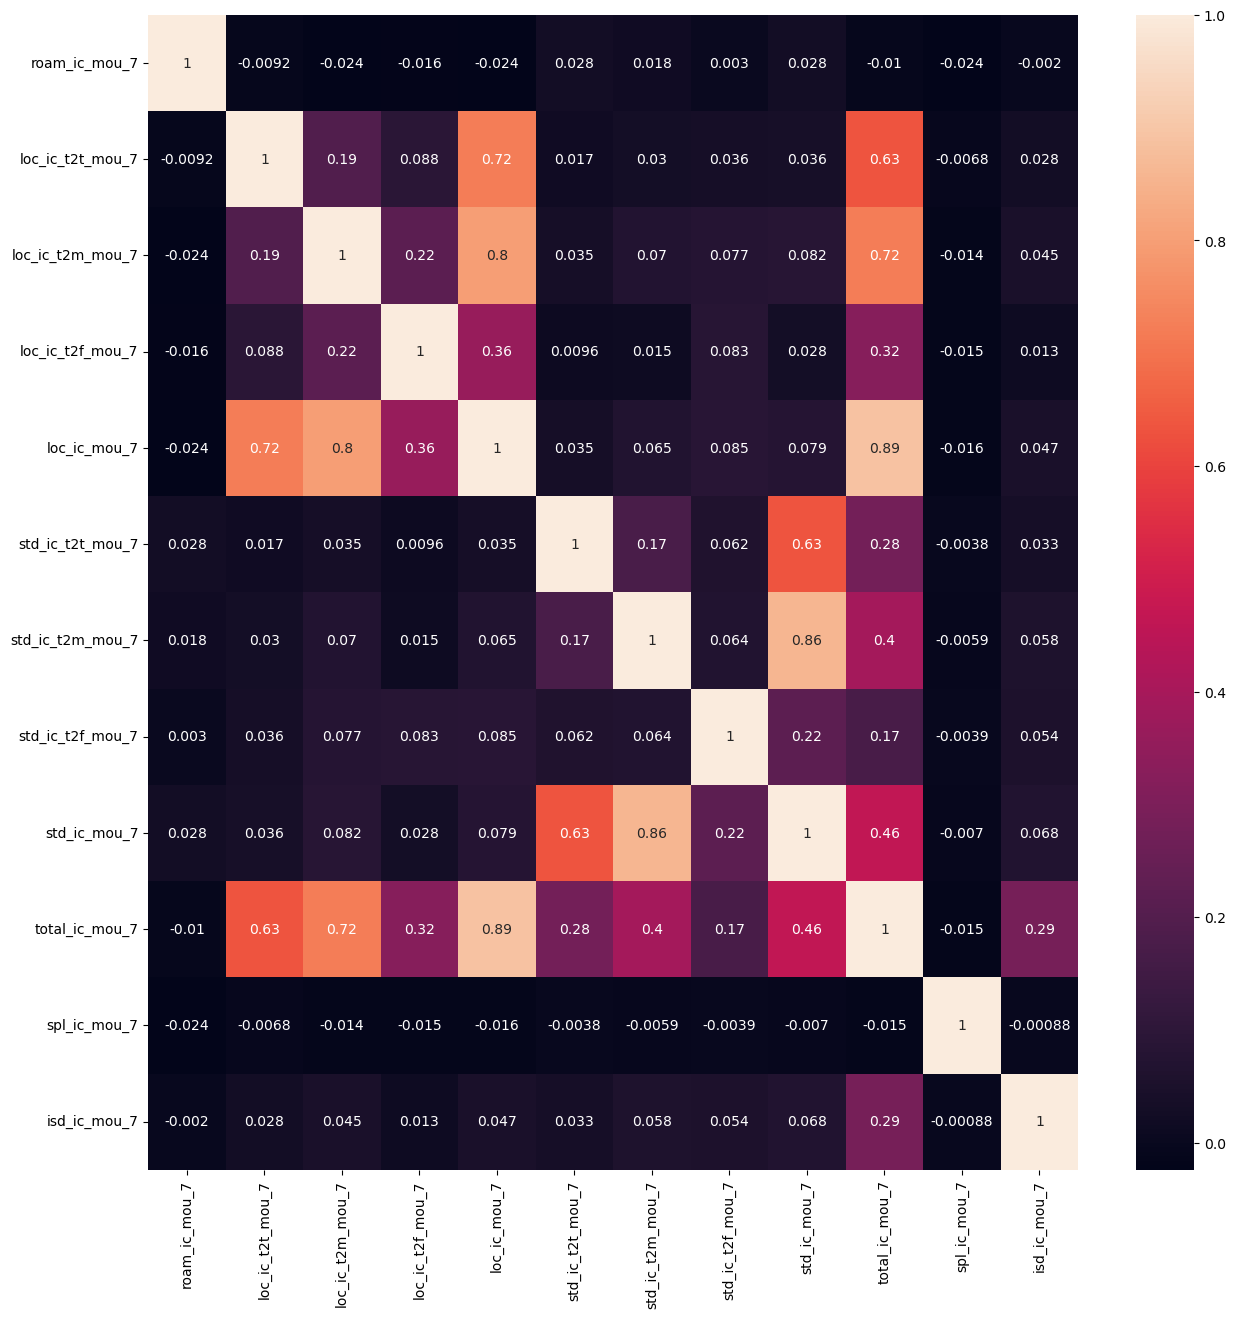

In [31]:
## finding out correlation between variables  within 7th Month
plt.figure(figsize = (15,15))
sns.heatmap(churn.filter(mou_ic_cols7).corr(),annot = True)
plt.show()

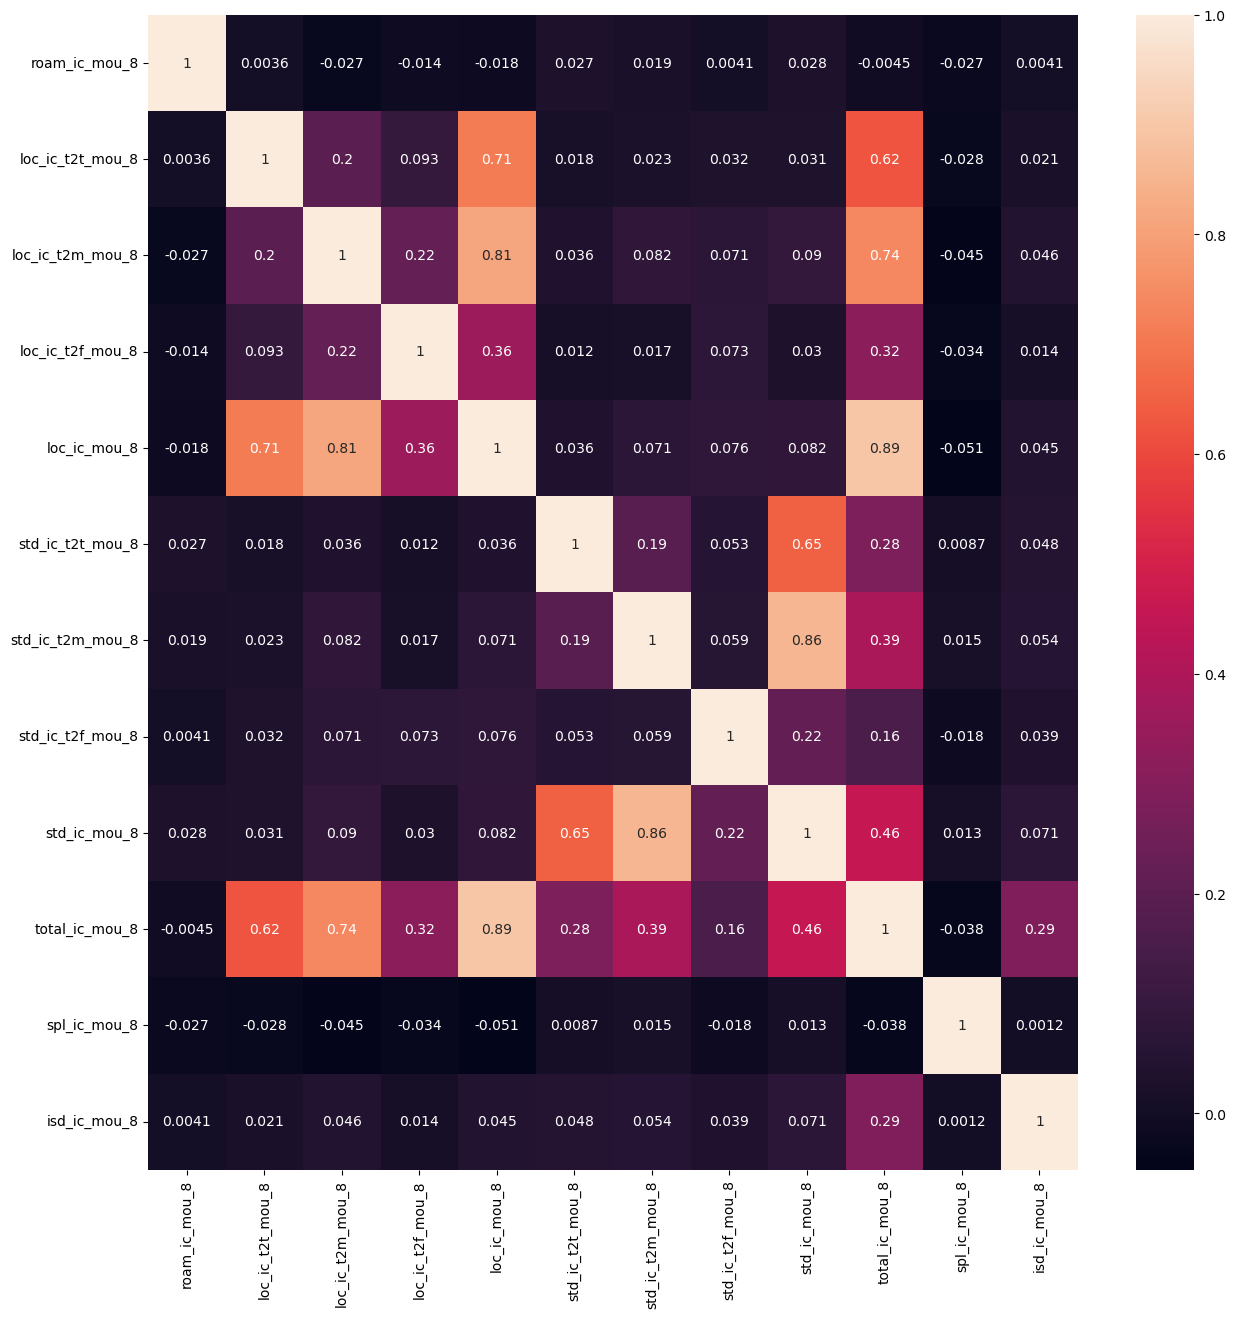

In [32]:
## finding out correlation between variables  within 8th Month
plt.figure(figsize = (15,15))
sns.heatmap(churn.filter(mou_ic_cols8).corr(),annot = True)
plt.show()

In [33]:
# function to correlate variables
def correlation(dataframe) : 
    columnsForAnalysis = [x for x in dataframe.columns.to_list() if x != 'churn_probability']
    cor0=dataframe[columnsForAnalysis].corr()
    type(cor0)
    cor0.where(np.triu(np.ones(cor0.shape),k=1).astype(np.bool))
    cor0=cor0.unstack().reset_index()
    cor0.columns=['VAR1','VAR2','CORR']
    cor0.dropna(subset=['CORR'], inplace=True)
    cor0.CORR=round(cor0['CORR'],2)
    cor0.CORR=cor0.CORR.abs()
    cor0.sort_values(by=['CORR'],ascending=False)
    cor0=cor0[~(cor0['VAR1']==cor0['VAR2'])]

    # removing duplicate correlations
    cor0['pair'] = cor0[['VAR1', 'VAR2']].apply(lambda x: '{}-{}'.format(*sorted((x[0], x[1]))), axis=1)
    
    cor0 = cor0.drop_duplicates(subset=['pair'], keep='first')
    cor0 = cor0[['VAR1', 'VAR2','CORR']]
    return pd.DataFrame(cor0.sort_values(by=['CORR'],ascending=False))

# Correlations for Churn : 0  - non churn customers
# Absolute values are reported
cor_0 = correlation(churn)

# filtering for correlations >= 40%
condition = cor_0['CORR'] > 0.4
cor_0 = cor_0[condition]
cor_0.style.background_gradient(cmap='GnBu')

#### Feature Engineering bettter analysis for  churn_probability

In [34]:
columns_to_drop = [
    'vol_2g_mb_8', 'vol_2g_mb_6', 'vol_2g_mb_7',
    'vol_3g_mb_8'  , 'vol_3g_mb_6', 'vol_3g_mb_7' ,
    'total_og_mou_8','total_og_mou_6', 'total_og_mou_7', 
    'total_ic_mou_8','total_ic_mou_6', 'total_ic_mou_7',
    'vbc_3g_8','vbc_3g_6','vbc_3g_7',
    'arpu_8','arpu_6','arpu_7',
    'total_rech_amt_8', 'total_rech_amt_6', 'total_rech_amt_7']

churn['delta_vol_2g'] = churn['vol_2g_mb_8'] - churn['vol_2g_mb_6'].add(churn['vol_2g_mb_7']).div(2)
churn['delta_vol_3g'] = churn['vol_3g_mb_8'] - churn['vol_3g_mb_6'].add(churn['vol_3g_mb_7']).div(2)
churn['delta_total_og_mou'] = churn['total_og_mou_8'] - churn['total_og_mou_6'].add(churn['total_og_mou_7']).div(2)
churn['delta_total_ic_mou'] = churn['total_ic_mou_8'] - churn['total_ic_mou_6'].add(churn['total_ic_mou_7']).div(2)
churn['delta_vbc_3g'] = churn['vbc_3g_8'] - churn['vbc_3g_6'].add(churn['vbc_3g_7']).div(2)

churn['delta_arpu'] = churn['arpu_8'] - churn['arpu_6'].add(churn['arpu_7']).div(2)
churn['delta_total_rech_amt'] = churn['total_rech_amt_8'] - churn['total_rech_amt_6'].add(churn['total_rech_amt_7']).div(2)

# Removing variables used for derivation : 
churn.drop(columns=columns_to_drop, inplace=True)

In [35]:
unseen['delta_vol_2g'] = unseen['vol_2g_mb_8'] - unseen['vol_2g_mb_6'].add(unseen['vol_2g_mb_7']).div(2)
unseen['delta_vol_3g'] = unseen['vol_3g_mb_8'] - unseen['vol_3g_mb_6'].add(unseen['vol_3g_mb_7']).div(2)
unseen['delta_total_og_mou'] = unseen['total_og_mou_8'] - unseen['total_og_mou_6'].add(unseen['total_og_mou_7']).div(2)
unseen['delta_total_ic_mou'] = unseen['total_ic_mou_8'] - unseen['total_ic_mou_6'].add(unseen['total_ic_mou_7']).div(2)
unseen['delta_vbc_3g'] = unseen['vbc_3g_8'] - unseen['vbc_3g_6'].add(unseen['vbc_3g_7']).div(2)

unseen['delta_arpu'] = unseen['arpu_8'] - unseen['arpu_6'].add(unseen['arpu_7']).div(2)
unseen['delta_total_rech_amt'] = unseen['total_rech_amt_8'] - unseen['total_rech_amt_6'].add(unseen['total_rech_amt_7']).div(2)

# Removing variables used for derivation : 
unseen.drop(columns=columns_to_drop, inplace=True)

In [36]:
#compute missing data
missing_data_percent = 100*(churn.isnull().sum()/len(churn)).sort_values(ascending=False)
missing_data_percent.head(30)

arpu_3g_6             74.902499
arpu_2g_6             74.902499
max_rech_data_6       74.902499
count_rech_2g_6       74.902499
total_rech_data_6     74.902499
fb_user_6             74.902499
count_rech_3g_6       74.902499
night_pck_user_6      74.902499
av_rech_amt_data_6    74.902499
max_rech_data_7       74.478207
count_rech_2g_7       74.478207
count_rech_3g_7       74.478207
av_rech_amt_data_7    74.478207
arpu_3g_7             74.478207
total_rech_data_7     74.478207
night_pck_user_7      74.478207
arpu_2g_7             74.478207
fb_user_7             74.478207
count_rech_3g_8       73.689624
fb_user_8             73.689624
max_rech_data_8       73.689624
night_pck_user_8      73.689624
arpu_3g_8             73.689624
count_rech_2g_8       73.689624
arpu_2g_8             73.689624
av_rech_amt_data_8    73.689624
total_rech_data_8     73.689624
loc_ic_t2m_mou_8       5.290076
og_others_8            5.290076
isd_ic_mou_8           5.290076
dtype: float64

### Dropping fields which have more than 50% of Missing values.

In [37]:
retained_variables = missing_data_percent[missing_data_percent.le(50)].index
churn = churn[retained_variables].copy(deep=True)
print(churn.shape)

(69999, 111)


### Missing Data Imputation - Most missing values indicate abscence of recharge or no usage. Will replace with a constant '0'

In [38]:
imputer = SimpleImputer(strategy='constant', fill_value=0)

missing_rows = churn.isnull().any()
impute_cols = list(missing_rows[missing_rows.gt(0)].index)
churn.loc[:,impute_cols] = imputer.fit_transform(churn[impute_cols])
unseen.loc[:,impute_cols] = imputer.transform(unseen[impute_cols])

In [39]:
exclusion_list = binary_cols + ['churn_probability']

#### Capping Outliers , 3 standard deviations limit.

In [40]:
exclusion_list = binary_cols + ['churn_probability']
predictor_cols = list(set(churn.columns) - set(exclusion_list))
churn.loc[:,predictor_cols] = churn[predictor_cols].apply(trim_outliers, axis=0)
unseen.loc[:,predictor_cols] = unseen[predictor_cols].apply(trim_outliers, axis=0)
churn.describe()

loc_ic_t2m_mou_8   og_others_8  isd_ic_mou_8  std_ic_t2f_mou_8  \
count      69999.000000  69999.000000  69999.000000      69999.000000   
mean          96.488171      0.008281      5.352176          1.451040   
std          123.262407      0.189737     23.977349          5.853758   
min            0.000000      0.000000      0.000000          0.000000   
25%           13.830000      0.000000      0.000000          0.000000   
50%           52.730000      0.000000      0.000000          0.000000   
75%          127.800000      0.000000      0.000000          0.000000   
max          593.138583      6.549423    192.209810         48.306505   

       spl_og_mou_8   ic_others_8  loc_ic_t2f_mou_8  spl_ic_mou_8  \
count  69999.000000  69999.000000      69999.000000  69999.000000   
mean       4.157952      0.600563          9.455458      0.033253   
std        9.478477      3.116712         21.990766      0.104331   
min        0.000000      0.000000          0.000000      0.000000   
25%        0.000000      0.000000          0.000000      0.000000   
50%        0.000000      0.000000          0.660000      0.000000   
75%        3.540000      0.000000          7.260000      0.000000   
max       56.590235     35.070591        124.086724      0.472416   

       isd_og_mou_8  loc_ic_t2t_mou_8  std_ic_t2m_mou_8  std_ic_mou_8  \
count  69999.000000      69999.000000      69999.000000  69999.000000   
mean       0.395919         39.274475         16.792453     26.865000   
std        4.649475         70.647290         39.688019     57.229459   
min        0.000000          0.000000          0.000000      0.000000   
25%        0.000000          2.030000          0.000000      0.000000   
50%        0.000000         14.080000          1.440000      4.680000   
75%        0.000000         43.560000         13.960000     25.510000   
max       87.111280        458.362973        258.439474    348.790522   

       loc_ic_mou_8  std_og_mou_8  loc_og_t2f_mou_8   onnet_mou_8  \
count  69999.000000  69999.000000      69999.000000  69999.000000   
mean     149.433275    149.589469          2.907660    112.473097   
std      185.153910    302.705257          7.368723    211.070937   
min        0.000000      0.000000          0.000000      0.000000   
25%       24.830000      0.000000          0.000000      4.110000   
50%       85.010000      7.310000          0.000000     27.840000   
75%      198.000000    130.665000          1.760000    106.280000   
max      894.712755   1370.666232         41.528699   1040.915263   

       offnet_mou_8  roam_ic_mou_8  roam_og_mou_8  loc_og_t2t_mou_8  \
count  69999.000000   69999.000000   69999.000000      69999.000000   
mean     174.114240       4.543311       6.692217         37.258621   
std      239.885425      20.600583      27.804966         75.424098   
min        0.000000       0.000000       0.000000          0.000000   
25%       23.780000       0.000000       0.000000          0.760000   
50%       83.010000       0.000000       0.000000         10.060000   
75%      216.410000       0.000000       0.000000         37.260000   
max     1141.507708     162.634026     198.026810        493.103768   

       std_og_t2f_mou_8  loc_og_t2m_mou_8  loc_og_t2c_mou_8  loc_og_mou_8  \
count      69999.000000      69999.000000      69999.000000  69999.000000   
mean           0.676650         80.563606          1.089767    124.017823   
std            3.086647        114.424899          3.418175    176.173948   
min            0.000000          0.000000          0.000000      0.000000   
25%            0.000000          6.440000          0.000000     11.660000   
50%            0.000000         35.940000          0.000000     57.010000   
75%            0.000000        103.110000          0.000000    156.980000   
max           23.484503        537.160266         20.469906    855.523990   

       std_og_t2t_mou_8  std_ic_t2t_mou_8  std_og_t2m_mou_8  isd_ic_mou_6  \
count      69999.000000      69999.0

## Modelling

In [41]:
X = churn.drop('churn_probability', axis=1)
y = churn['churn_probability']

X.shape, y.shape

((69999, 110), (69999,))

In [42]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=RANDOM_STATE)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((55999, 110), (14000, 110), (55999,), (14000,))

In [43]:
#filtering out unnessesary columns from test data
unseen =  unseen[X_train.columns]
print(unseen.shape)

(30000, 110)


In [44]:
scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train)
X_test_scaled = scale.transform(X_test)
unseen_scaled = scale.transform(unseen)

## Using PCA to reduce dimensions

In [45]:
from sklearn.decomposition import PCA 
pca = PCA(random_state = RANDOM_STATE) 
pca.fit(X_train_scaled)

PCA(random_state=42)

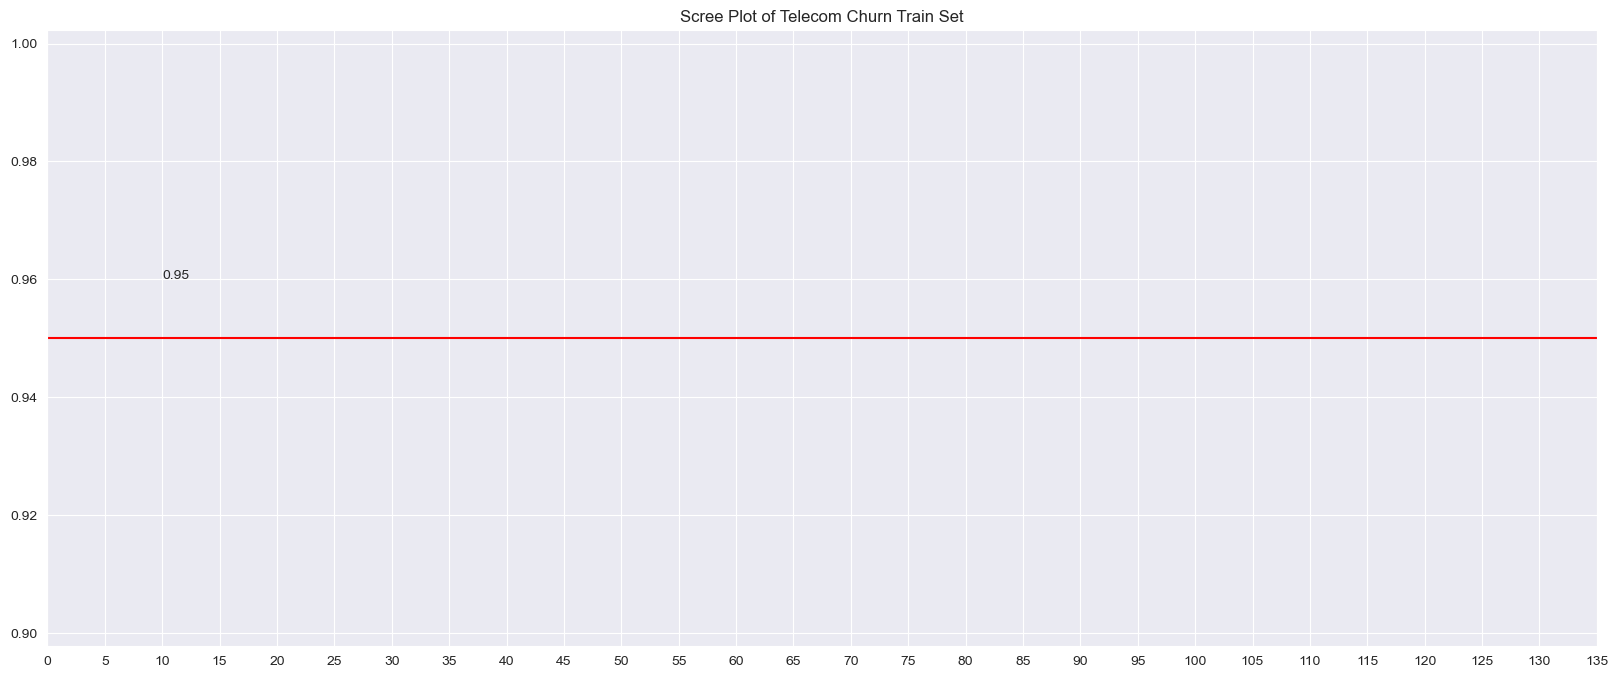

In [46]:
# Scree Plot to pick the number of components

var_cum = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(20,8))
sns.set_style('darkgrid')
sns.lineplot(var_cum)
plt.xticks(np.arange(0,140,5))
plt.axhline(0.95,color='r')
plt.text(10,0.96,'0.95')

plt.title('Scree Plot of Telecom Churn Train Set');

## 65 Components Explain 95% of the data variance

In [47]:
pca_final = PCA(n_components=65, random_state=RANDOM_STATE)
transformed_data = pca_final.fit_transform(X_train_scaled)
X_train_pca = pd.DataFrame(transformed_data, columns=["PC_"+str(x) for x in range(1,66)], index = X_train.index)
data_train_pca = pd.concat([X_train_pca, y_train], axis=1)
X_test_pca = pd.DataFrame(pca_final.transform(X_test_scaled),columns=["PC_"+str(x) for x in range(1,66)], index = X_test.index)
unseen_pca = pd.DataFrame(pca_final.transform(unseen_scaled),columns=["PC_"+str(x) for x in range(1,66)], index = unseen.index)

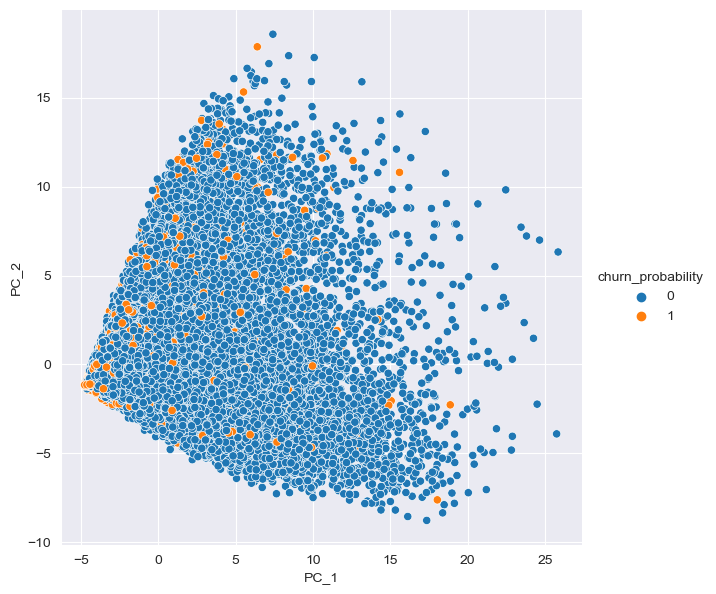

In [48]:
## Plotting principal components 
sns.pairplot(data=data_train_pca, x_vars=["PC_1"], y_vars=["PC_2"], hue = "churn_probability", size=6);

### PCA Random Forest

In [51]:
pca_rf = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced',n_jobs=-1)

In [50]:
%%time 
# Hyper parameter Tuning
params = {
    'n_estimators'  : [100],
    'max_depth' : [9,10,11],
    'min_samples_leaf' : [5,10,15,20]
}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
pca_rf_model_search = GridSearchCV(estimator=pca_rf, param_grid=params, 
                                   cv=folds, scoring='average_precision', verbose=True, n_jobs=-1 )

pca_rf_model_search.fit(X_train_pca, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Wall time: 16min


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [9, 10, 11],
                         'min_samples_leaf': [5, 10, 15, 20],
                         'n_estimators': [100]},
             scoring='average_precision', verbose=True)

#### Optimised for average precision as auc_roc is over-optimistic for imbalanced datasets.

In [52]:
# Optimum Hyperparameters
print('Best Average Precision score :', pca_rf_model_search.best_score_)
print('Best Parameters :', pca_rf_model_search.best_params_)

Best Average Precision score : 0.5778398776959349
Best Parameters : {'max_depth': 11, 'min_samples_leaf': 20, 'n_estimators': 100}


In [53]:
# Modelling using the best PCA-RandomForest Estimator 
pca_rf_best = RandomForestClassifier(**pca_rf_model_search.best_params_,
                                     class_weight='balanced',
                                     random_state=RANDOM_STATE)
pca_rf_best_fit = pca_rf_best.fit(X_train_pca, y_train)

# Prediction on Train set
y_train_pred_pca_rf_best = pca_rf_best_fit.predict(X_train_pca)
y_train_prob_pca_rf_best = pca_rf_best_fit.predict_proba(X_train_pca)
y_test_pred_pca_rf_best = pca_rf_best_fit.predict(X_test_pca)
y_test_prob_pca_rf_best = pca_rf_best_fit.predict_proba(X_test_pca)

#### Evaluating The PCA Random Forest Model

In [54]:
best_rf_pca_report = classification_report(y_train,y_train_pred_pca_rf_best)
bal_accuracy =  balanced_accuracy_score(y_train,y_train_pred_pca_rf_best)
print('\nTraining Data:\n')
print(f'\n Accuracy Factoring In Class Imbalance: {round(bal_accuracy,2)}\n')
print(best_rf_pca_report)


Training Data:


 Accuracy Factoring In Class Imbalance: 0.88

              precision    recall  f1-score   support

           0       0.98      0.91      0.94     50289
           1       0.52      0.86      0.65      5710

    accuracy                           0.90     55999
   macro avg       0.75      0.88      0.80     55999
weighted avg       0.94      0.90      0.91     55999



In [55]:
best_rf_pca_report_test = classification_report(y_test,y_test_pred_pca_rf_best)
bal_accuracy_test =  balanced_accuracy_score(y_test,y_test_pred_pca_rf_best)
print('\nTest Data:\n')
print(f'\n Accuracy Factoring In Class Imbalance: {round(bal_accuracy_test,2)}\n')
print(best_rf_pca_report_test)


Test Data:


 Accuracy Factoring In Class Imbalance: 0.84

              precision    recall  f1-score   support

           0       0.97      0.90      0.94     12578
           1       0.47      0.78      0.59      1422

    accuracy                           0.89     14000
   macro avg       0.72      0.84      0.76     14000
weighted avg       0.92      0.89      0.90     14000



#### Has Decent recall, but the  precision takes a hit for the 'churn' class.

In [70]:
sample.to_csv("Yukti_Lal_Rajani_Malle.csv",index=False)

In [57]:
precision_, recall_, proba = precision_recall_curve(y_train, y_train_prob_pca_rf_best[:, -1])
optimal_proba_cutoff = sorted(list(zip(np.abs(precision_ - recall_), proba)), key=lambda i: i[0], reverse=False)[0][1]
print(f"Optimal Probability Threshold: {optimal_proba_cutoff}\n")
roc_predictions = [1 if i >= optimal_proba_cutoff else 0 for i in y_train_prob_pca_rf_best[:, -1]]
test_roc_predictions = [1 if i >= optimal_proba_cutoff else 0 for i in y_test_prob_pca_rf_best[:, -1]]
print(f"Training Report After caliberation : {classification_report(y_train,roc_predictions)}\n")
print(f"Test Report After caliberation{classification_report(y_test,test_roc_predictions)}\n")

Optimal Probability Threshold: 0.690564896321487

Training Report After caliberation :               precision    recall  f1-score   support

           0       0.96      0.96      0.96     50289
           1       0.68      0.68      0.68      5710

    accuracy                           0.93     55999
   macro avg       0.82      0.82      0.82     55999
weighted avg       0.93      0.93      0.93     55999


Test Report After caliberation              precision    recall  f1-score   support

           0       0.95      0.96      0.95     12578
           1       0.61      0.54      0.57      1422

    accuracy                           0.92     14000
   macro avg       0.78      0.75      0.76     14000
weighted avg       0.91      0.92      0.92     14000




- Precision is a higher priority than recall for churn analysis. So we'll stick to optimal threshold of 0.690

**Modeling using Random Forest without PCA**

In [58]:
rf = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced',n_jobs=-1,oob_score=True)

In [59]:
%%time
rf.fit(X_train,y_train)
rf.oob_score_

Wall time: 16.4 s


0.9397132091644493

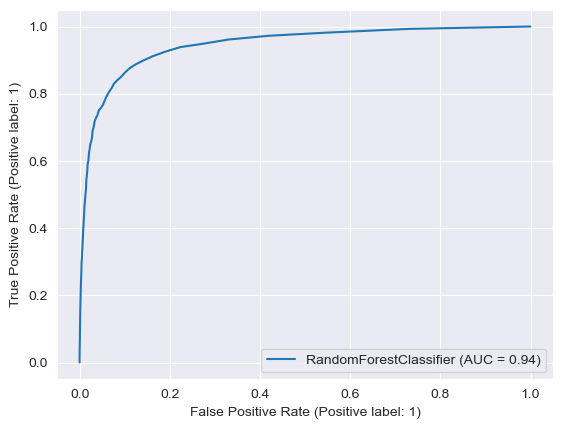

In [60]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.show()

**Hyper-parameter tuning for the Random Forest**

In [63]:
rf = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1)
rf.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [62]:
%%time
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],    
    'n_estimators': [10, 25, 50, 100]
}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = folds,
                           n_jobs=-1, verbose=1, scoring="average_precision")
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Wall time: 22min 54s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='average_precision', verbose=1)

In [64]:
# Optimum Hyperparameters
print('Best Average Precision score :', grid_search.best_score_)
print('Best Parameters :', grid_search.best_params_)

Best Average Precision score : 0.742479563046767
Best Parameters : {'max_depth': 20, 'min_samples_leaf': 10, 'n_estimators': 100}


In [65]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=10, n_jobs=-1, random_state=42)

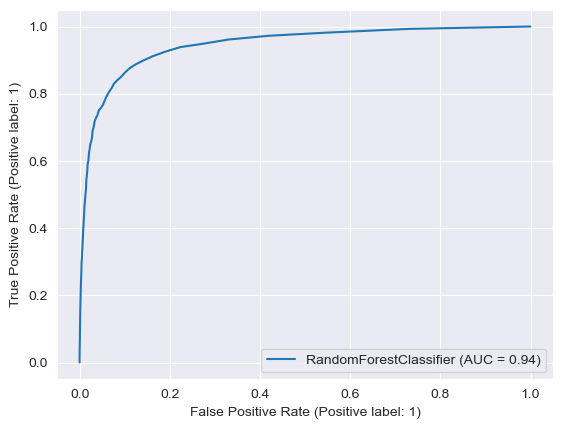

In [66]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.show()

In [67]:
rf_best.feature_importances_

array([7.36336942e-02, 1.35499726e-06, 1.14589337e-03, 2.26957305e-03,
       7.51045667e-03, 1.47572337e-03, 3.01304126e-02, 6.14043013e-03,
       7.48645004e-04, 4.73555334e-02, 7.11330171e-03, 1.47292659e-02,
       1.02025302e-01, 8.86047964e-03, 7.07878881e-03, 2.30667699e-02,
       2.15882579e-02, 2.36706701e-02, 3.22839915e-02, 3.55563362e-02,
       5.00075913e-04, 6.81577333e-02, 1.49028030e-03, 7.14111172e-02,
       3.51257422e-03, 3.61663238e-03, 8.39512428e-03, 9.24935080e-04,
       8.23155790e-04, 8.93253921e-04, 7.69829228e-04, 2.94452407e-03,
       4.25032748e-03, 3.18800115e-03, 2.28406774e-03, 4.98929501e-03,
       4.07365191e-03, 2.07433202e-03, 4.27604734e-04, 3.11177660e-03,
       2.01751269e-03, 2.55782545e-03, 5.71174315e-03, 8.88051588e-04,
       8.41705219e-04, 5.09634920e-03, 2.72025981e-04, 1.70725503e-03,
       5.09801087e-03, 3.85290208e-03, 8.38614515e-03, 1.76405407e-03,
       7.69202605e-03, 4.13170979e-03, 4.80396310e-03, 5.55388132e-03,
      

In [68]:
imp_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": rf_best.feature_importances_
})

In [69]:
imp_df.sort_values(by="Imp", ascending=False)

Varname       Imp
12           loc_ic_mou_8  0.102025
0        loc_ic_t2m_mou_8  0.073634
23           loc_og_mou_8  0.071411
21       loc_og_t2m_mou_8  0.068158
9        loc_ic_t2t_mou_8  0.047356
98     last_day_rch_amt_8  0.045298
19       loc_og_t2t_mou_8  0.035556
18          roam_og_mou_8  0.032284
6        loc_ic_t2f_mou_8  0.030130
106        max_rech_amt_8  0.029613
85     delta_total_og_mou  0.025413
17          roam_ic_mou_8  0.023671
15            onnet_mou_8  0.023067
16           offnet_mou_8  0.021588
109  delta_total_rech_amt  0.021500
88             delta_arpu  0.021450
86     delta_total_ic_mou  0.019463
11           std_ic_mou_8  0.014729
75       loc_ic_t2m_mou_7  0.012437
71           loc_ic_mou_7  0.012304
77       loc_ic_t2t_mou_7  0.008888
13           std_og_mou_8  0.008860
82                    aon  0.008739
26       std_og_t2m_mou_8  0.008395
50           loc_ic_mou_6  0.008386
52       loc_ic_t2m_mou_6  0.007692
4            spl_og_mou_8  0.007510
10       std_ic_t2m_mou_8  0.007113
14       loc_og_t2f_mou_8  0.007079
64       loc_og_t2m_mou_7  0.006653
58           loc_og_mou_7  0.006296
7            spl_ic_mou_8  0.006140
103      total_rech_num_8  0.005788
42           loc_og_mou_6  0.005712
55           offnet_mou_7  0.005554
63           std_og_mou_7  0.005287
73            onnet_mou_7  0.005263
48           offnet_mou_6  0.005098
45       loc_ic_t2t_mou_6  0.005096
35       loc_og_t2m_mou_6  0.004989
54       loc_og_t2t_mou_7  0.004804
83           delta_vol_2g  0.004764
32            onnet_mou_6  0.004250
53       loc_ic_t2f_mou_6  0.004132
36           std_og_mou_6  0.004074
102      total_rech_num_7  0.003982
49       loc_og_t2t_mou_6  0.003853
57       std_og_t2m_mou_7  0.003765
104        max_rech_amt_6  0.003701
74           std_ic_mou_7  0.003700
105        max_rech_amt_7  0.003649
25       std_ic_t2t_mou_8  0.003617
24       std_og_t2t_mou_8  0.003513
101      total_rech_num_6  0.003352
80           spl_og_mou_7  0.003336
66       std_og_t2t_mou_7  0.003249
69       loc_ic_t2f_mou_7  0.003212
33           std_ic_mou_6  0.003188
70       std_ic_t2m_mou_7  0.003157
39       std_og_t2m_mou_6  0.003112
108    last_day_rch_amt_7  0.002962
31       std_ic_t2m_mou_6  0.002945
62       loc_og_t2f_mou_7  0.002932
84           delta_vol_3g  0.002906
107    last_day_rch_amt_6  0.002693
41       std_og_t2t_mou_6  0.002558
59          roam_ic_mou_7  0.002533
61          roam_og_mou_7  0.002476
34       loc_og_t2f_mou_6  0.002284
65       std_ic_t2t_mou_7  0.002271
3        std_ic_t2f_mou_8  0.002270
37           spl_og_mou_6  0.002074
40       std_ic_t2t_mou_6  0.002018
51          roam_og_mou_6  0.001764
87           delta_vbc_3g  0.001738
47          roam_ic_mou_6  0.001707
22       loc_og_t2c_mou_8  0.001490
5             ic_others_8  0.001476
60       loc_og_t2c_mou_7  0.001311
2            isd_ic_mou_8  0.001146
79            ic_others_7  0.001047
95            sachet_2g_8  0.001038
27           isd_ic_mou_6  0.000925
29            ic_others_6  0.000893
43       loc_og_t2c_mou_6  0.000888
44            og_others_6  0.000842
28           spl_ic_mou_6  0.000823
72       std_ic_t2f_mou_7  0.000778
30       std_ic_t2f_mou_6  0.000770
93           monthly_2g_8  0.000751
8            isd_og_mou_8  0.000749
78           isd_ic_mou_7  0.000679
96            sachet_2g_7  0.000643
92           monthly_3g_8  0.000564
56       std_og_t2f_mou_7  0.000502
20       std_og_t2f_mou_8  0.000500
89            sachet_3g_8  0.000494
67           isd_og_mou_7  0.000489
76           spl_ic_mou_7  0.000470
38       std_og_t2f_mou_6  0.000428
97            sachet_2g_6  0.000411
99           monthly_2g_7  0.000398
100          monthly_2g_6  0.000288
46           isd_og_mou_6  0.000272
94           monthly_3g_6  0.000265
90            sachet_3g_7  0.000197
81           monthly_3g_7  0.000182
91            sachet_3g_6  0.000124
1             og_others_8  0.000001
68            og_others_7  0.000000